In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, MaxPool2D,
    Conv2DTranspose, Concatenate, Input, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
)
from tensorflow.keras.optimizers import Adam
from glob import glob
import cv2

# Set seeds for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

# GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Hyperparameters
batch_size = 2  # Adjust the batch size if needed
epochs = 50
height, width = 640, 640  # Ensure the dimensions match your data
input_shape = (height, width, 3)
lr = 1e-4  # Learning rate

# Define convolution block
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)  # Add Dropout layer
    return x

# Define encoder block
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Define decoder block
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

# Build U-Net model for segmentation
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)  # Adjust the number of filters if needed
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    bl = conv_block(p4, 512)

    dl = decoder_block(bl, s4, 256)
    d2 = decoder_block(dl, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    segmentation_output = Conv2D(2, 1, padding="same", activation="softmax", name="segmentation")(d4)
    model = Model(inputs, segmentation_output, name="UNET")
    return model

# Define paths and create directories
data_dir = r"/home/user/unet/data"
files_dir = data_dir

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created.")
    else:
        print(f"Directory {directory} already exists.")

create_dir(files_dir)
model_file = os.path.join(files_dir, "unet-model.keras")
log_file = os.path.join(files_dir, "log.csv")

# Function to load and split data
def load_data(data_dir):
    def get_data_paths(subset):
        images = sorted(glob(os.path.join(data_dir, subset, "*.png")))
        masks_class_0 = sorted(glob(os.path.join(data_dir, subset, "*_class_0_mask.npy")))
        masks_class_1 = sorted(glob(os.path.join(data_dir, subset, "*_class_1_mask.npy")))
        return images, masks_class_0, masks_class_1
    
    train_x, train_y0, train_y1 = get_data_paths("train")
    valid_x, valid_y0, valid_y1 = get_data_paths("val")
    test_x, test_y0, test_y1 = get_data_paths("test")

    train_y = [(y0, y1) for y0, y1 in zip(train_y0, train_y1)]
    valid_y = [(y0, y1) for y0, y1 in zip(valid_y0, valid_y1)]
    test_y = [(y0, y1) for y0, y1 in zip(test_y0, test_y1)]

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

# Functions to read images and masks
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    return x.astype(np.float32)

def read_mask(paths):
    paths = [path.decode() for path in paths]
    mask_class_0 = np.load(paths[0])
    mask_class_1 = np.load(paths[1])
    mask_class_0 = cv2.resize(mask_class_0, (width, height), interpolation=cv2.INTER_NEAREST)
    mask_class_1 = cv2.resize(mask_class_1, (width, height), interpolation=cv2.INTER_NEAREST)
    mask = np.stack([mask_class_0, mask_class_1], axis=-1)
    return mask.astype(np.float32)

# TensorFlow parsing and dataset functions
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 2])  # Two channels for the masks
    return x, y

# Data augmentation function
@tf.function
def augment_data(image, mask):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    mask = tf.image.random_flip_left_right(mask)
    mask = tf.image.random_flip_up_down(mask)
    return image, mask

def tf_dataset(x, y, batch_size=4, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.map(lambda x, y: augment_data(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()  # Repeat the dataset indefinitely
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Load the dataset
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(data_dir)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

# Create datasets
train_dataset = tf_dataset(train_x, train_y, batch_size, augment=True)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size)
test_dataset = tf_dataset(test_x, test_y, batch_size)

for x, y in valid_dataset:
    print(x.shape, y.shape)
    break

# Build and compile the model
model = build_unet(input_shape)
opt = Adam(learning_rate=lr)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

# Callbacks for training
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks,
    steps_per_epoch=max(len(train_x) // batch_size, 1),
    validation_steps=max(len(valid_x) // batch_size, 1)
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset, steps=len(test_x) // batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save(model_file)


1 Physical GPUs, 1 Logical GPUs
Directory /home/user/unet/data already exists.
Train: 401 - 401
Valid: 86 - 86
Test: 86 - 86
(2, 640, 640, 3) (2, 640, 640, 2)


Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 640, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 640, 640,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 640, 640,  │        128 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 640, 640,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 640, 640,  │      9,248 │ activation_40[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 640, 640,  │        128 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 640, 640,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 640, 640,  │          0 │ activation_41[0]… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 320, 320,  │          0 │ dropout_20[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 320, 320,  │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 320, 320,  │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_42       │ (None, 320, 320,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 320, 320,  │     36,928 │ activation_42[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 320, 320,  │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_43       │ (None, 320, 320,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 320, 320,  │          0 │ activation_43[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 160, 160,  │          0 │ dropout_21[0][0]

 Total params: 7,771,906 (29.65 MB)

 Trainable params: 7,766,018 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

Epoch 1/50


2024-07-18 03:43:29.298477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 23330816 bytes after encountering the first element of size 23330816 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6278 - loss: 19.5028
Epoch 1: val_loss improved from inf to 5.96534, saving model to /home/user/unet/data/unet-model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 59s 206ms/step - accuracy: 0.6274 - loss: 19.4742 - val_accuracy: 0.7935 - val_loss: 5.9653 - learning_rate: 1.0000e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4441 - loss: 4.7266
Epoch 2: val_loss improved from 5.96534 to 2.38470, saving model to /home/user/unet/data/unet-model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 180ms/step - accuracy: 0.4442 - loss: 4.7218 - val_accuracy: 0.1843 - val_loss: 2.3847 - learning_rate: 1.0000e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.4939 - loss: 2.1118
Epoch 3: val_loss improved from 2.38470 to 1.39377, saving model to /home/user/unet/data/unet-model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - accuracy: 0.4939 - loss: 2.1105 - val_accuracy: 0.3493 - val_loss: 1.3938 - learning_rate

### Script to convert .png to .npy

In [8]:
import os
import numpy as np
import cv2
from glob import glob

def convert_png_to_npy(data_dir):
    subsets = ["train", "val", "test"]
    for subset in subsets:
        mask_dir = os.path.join(data_dir, subset, "masks")
        if not os.path.exists(mask_dir):
            print(f"Directory {mask_dir} does not exist, skipping...")
            continue
        
        png_files = glob(os.path.join(mask_dir, "*.png"))
        if not png_files:
            print(f"No PNG files found in {mask_dir}, skipping...")
            continue
        
        for png_file in png_files:
            try:
                # Read the PNG file
                mask = cv2.imread(png_file, cv2.IMREAD_GRAYSCALE)
                
                # Check if the mask was read properly
                if mask is None:
                    print(f"Failed to read {png_file}, skipping...")
                    continue
                
                # Convert mask to binary format (0 and 255 to 0 and 1)
                mask = np.where(mask > 0, 1, 0).astype(np.uint8)
                
                # Save as NPY file
                npy_file = png_file.replace(".png", ".npy")
                np.save(npy_file, mask)
                
                # Remove the original PNG file
                os.remove(png_file)
                print(f"Converted {png_file} to {npy_file}")
            except Exception as e:
                print(f"Error processing {png_file}: {e}")

# Path to your data
data_dir = r"/home/user/unet/data"

# Convert PNG masks to NPY format
convert_png_to_npy(data_dir)


Converted /home/user/unet/data/train/masks/nmet 46_class_0_mask.png to /home/user/unet/data/train/masks/nmet 46_class_0_mask.npy
Converted /home/user/unet/data/train/masks/nmet 21_class_1_mask.png to /home/user/unet/data/train/masks/nmet 21_class_1_mask.npy
Converted /home/user/unet/data/train/masks/met 95_class_0_mask.png to /home/user/unet/data/train/masks/met 95_class_0_mask.npy
Converted /home/user/unet/data/train/masks/met 83_class_1_mask.png to /home/user/unet/data/train/masks/met 83_class_1_mask.npy
Converted /home/user/unet/data/train/masks/nmet 99_class_1_mask.png to /home/user/unet/data/train/masks/nmet 99_class_1_mask.npy
Converted /home/user/unet/data/train/masks/nmet 197_class_1_mask.png to /home/user/unet/data/train/masks/nmet 197_class_1_mask.npy
Converted /home/user/unet/data/train/masks/nmet 68_class_1_mask.png to /home/user/unet/data/train/masks/nmet 68_class_1_mask.npy
Converted /home/user/unet/data/train/masks/nmet 82_class_0_mask.png to /home/user/unet/data/train/m

### Test on sample data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


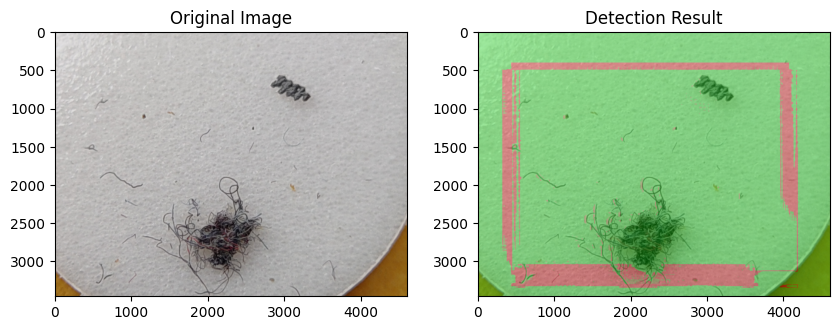

In [9]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Set the paths
#model_path = r"/home/user/unet/data/unet-model.keras"
model_path = r"/home/user/unet/data/unet-model.keras"
image_path = r"/home/user/unet/my-mobile-images/1 (16).jpg"  # Update with the path to your image
output_path = r"/home/user/unet/my-mobile-images/detected/detect_1_(19).png"  # Path to save the output mask

# Load the trained model
model = load_model(model_path)

# Define the image dimensions (should match the dimensions used during training)
height, width = 640, 640

# Function to preprocess the input image
def preprocess_image(image_path, height, width):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (width, height))
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to post-process the output mask
def postprocess_mask(mask, original_image_path, output_path):
    mask = mask.squeeze()  # Remove batch dimension
    mask = np.argmax(mask, axis=-1)  # Get the class with the highest probability
    mask = mask.astype(np.uint8)  # Convert to uint8
    original_image = cv2.imread(original_image_path, cv2.IMREAD_COLOR)
    original_height, original_width = original_image.shape[:2]
    mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)  # Resize to original image size

    # Create a colored mask to distinguish between classes
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    color_mask[mask == 0] = [0, 255, 0]  # Green for metal
    color_mask[mask == 1] = [0, 0, 255]  # Red for non-metal

    # Blend the original image and the color mask
    blended_image = cv2.addWeighted(original_image, 0.7, color_mask, 0.3, 0)

    # Save the blended image
    cv2.imwrite(output_path, blended_image)
    return blended_image

# Preprocess the image
image = preprocess_image(image_path, height, width)

# Predict the segmentation mask
predicted_mask = model.predict(image)

# Post-process and save the mask
mask = postprocess_mask(predicted_mask, image_path, output_path)

# Display the original image and the mask
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
mask_image = cv2.imread(output_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Detection Result")
plt.imshow(cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB))

plt.show()


### Convert log results to plots

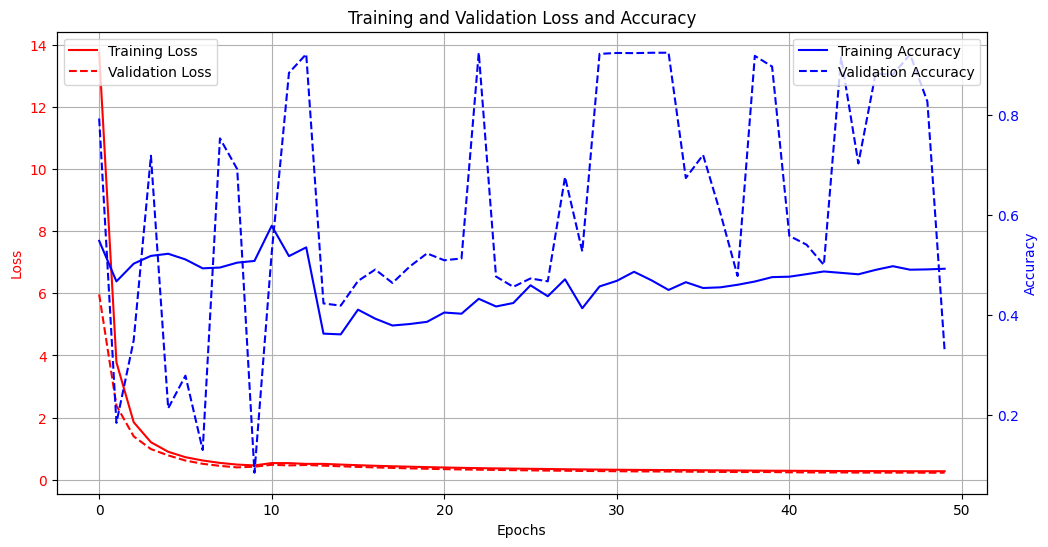

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
log_file = "/home/user/unet/data/log.csv"  # Update the path to your log file

# Read the CSV file
df = pd.read_csv(log_file)

# Extract relevant metrics
epochs = df['epoch']
train_loss = df['loss']
val_loss = df['val_loss']
train_accuracy = df['accuracy']
val_accuracy = df['val_accuracy']

# Create a combined plot for loss and accuracy
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot training and validation loss
ax1.plot(epochs, train_loss, 'r', label='Training Loss')
ax1.plot(epochs, val_loss, 'r--', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.legend(loc='upper left')
ax1.grid()

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'b--', label='Validation Accuracy')
ax2.set_ylabel('Accuracy', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.legend(loc='upper right')

# Add a title
plt.title('Training and Validation Loss and Accuracy')

# Save the plot as an image
plt.savefig('/home/user/unet/data/training_validation_loss_accuracy.png')  # Save the plot as an image
plt.show()
